In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras

In [2]:
# Nombre de points totals
N = 1000
# Nombre de points d'entrainement 
n_train = 300  
# Création de données synthétiques
x = np.linspace(1, 10, 1000) # changer en np.linspace(0, 10, 1000) pour les fonctions sans le log()

OBJECTIF : Comparer NN et PG sur la prédiction d'une fonction à l'aide de n_train points pour prédire N points ensuite

Fonction à prédire

In [3]:
#y = np.cos(x)
y = np.cos(x) + x**2 -20 * np.sin(5 * x) 
#y = np.log(x) + np.cos(x**2)*4*x

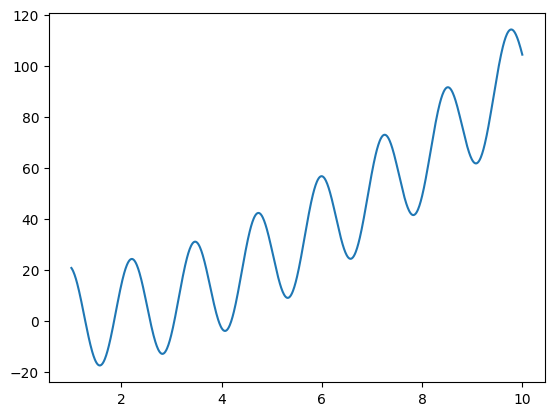

In [4]:
plt.plot(x, y, label='Données originales')

Testons avec differents kernels


Mean Squared Error : 3.640248207902703e-09


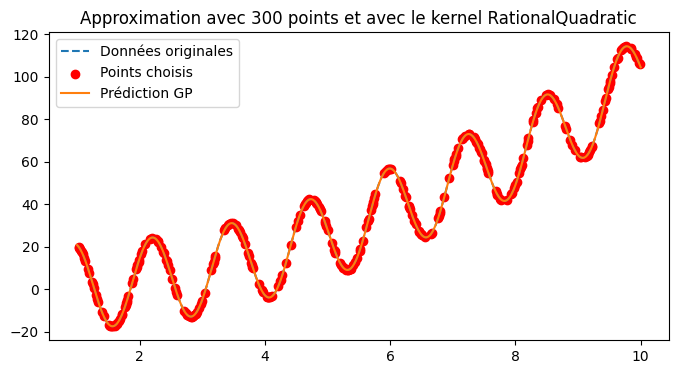

Mean Squared Error : 2.8050553665488582e-09


c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 2 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


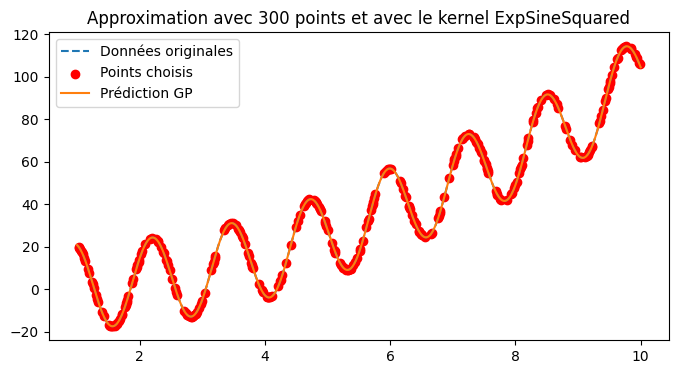

Mean Squared Error : 5.314266790556223e-05


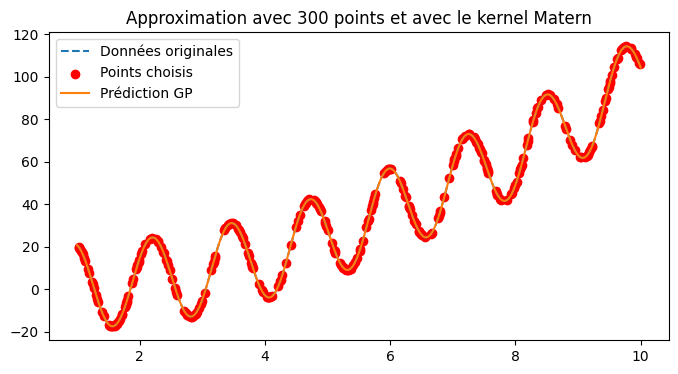

Mean Squared Error : 1.648040993894929e-06


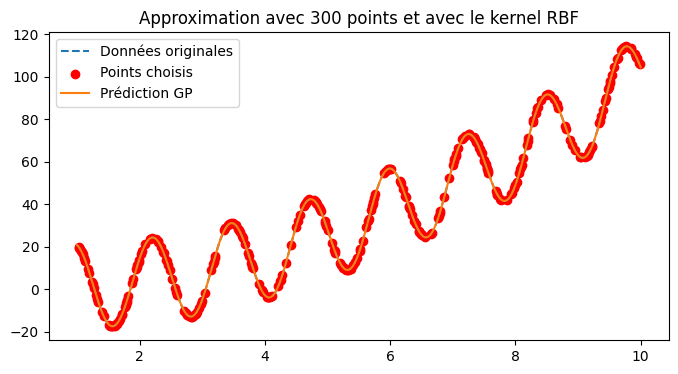

In [8]:
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import Matern
kernel_possible = ["RationalQuadratic", "ExpSineSquared", "Matern","RBF"] # "RBF" (celui par défaut)
indices = np.random.choice(range(N), size=n_train, replace=False)
x_chosen = x[indices]
y_chosen = y[indices]
for kernel_name  in kernel_possible:
     isRBF = False
     if(kernel_name == "RationalQuadratic"):
          kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)
     elif(kernel_name == "ExpSineSquared"):
          kernel = ExpSineSquared(length_scale=1.0, periodicity=3.0) 
     elif(kernel_name == "Matern"):
          kernel = Matern(length_scale=1.0, nu=1.5)
     else:
         isRBF = True
     plt.figure(figsize=(8, 4))

     # Données originales et points choisis
     plt.plot(x, y, label='Données originales', linestyle='dashed')
     plt.scatter(x_chosen, y_chosen, color='red', label='Points choisis')
     # Modèle de processus gaussien
     if (isRBF == False): 
         gp = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kernel)
     else:
         gp = sklearn.gaussian_process.GaussianProcessRegressor() # RBF par défaut
         
     gp.fit(x_chosen.reshape(-1, 1), y_chosen.reshape(-1, 1)) # ebtrainement avec n_train points

     y_pred = gp.predict(x.reshape(-1, 1)) # Prédiction avec 1000 points
     mse = mean_squared_error(y, y_pred)
     print("Mean Squared Error :", mse)
     # Prédiction
     plt.plot(x, y_pred, label='Prédiction GP')

     plt.legend()
     plt.title(f"Approximation avec {n_train} points et avec le kernel {kernel_name}")
     plt.show()

Comparaison avec un NN

In [9]:
# Normalisation
x_chosen_norm = (x_chosen - x_chosen.min()) / (x_chosen.max() - x_chosen.min())
x_norm = (x - x_chosen.min()) / (x_chosen.max() - x_chosen.min())

y_mean, y_std = np.mean(y_chosen), np.std(y_chosen)
y_chosen_norm = (y_chosen - y_mean) / y_std

In [10]:
inputs = tf.keras.Input(shape=(1,))
x1 = tf.keras.layers.Dense(256, activation='tanh')(inputs)
x2 = tf.keras.layers.Dense(256, activation='tanh')(x1)
x3 = tf.keras.layers.Dense(128, activation='tanh')(x2)
outputs = tf.keras.layers.Dense(1, activation='linear')(x3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Entraînement
model.fit(x_chosen_norm, y_chosen_norm, epochs=300, batch_size=128, verbose=0)


In [11]:
# Prédiction
y_pred_norm = model.predict(x_norm).flatten()
y_pred = y_pred_norm * y_std + y_mean
# MSE
mse_nn = mean_squared_error(y, y_pred)
print("MSE NN :", mse_nn)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE NN : 200.93776892287806


Le .flatten() dans y_pred_norm = model.predict(x_feat).flatten() sert à transformer la sortie du réseau en un vecteur 1D

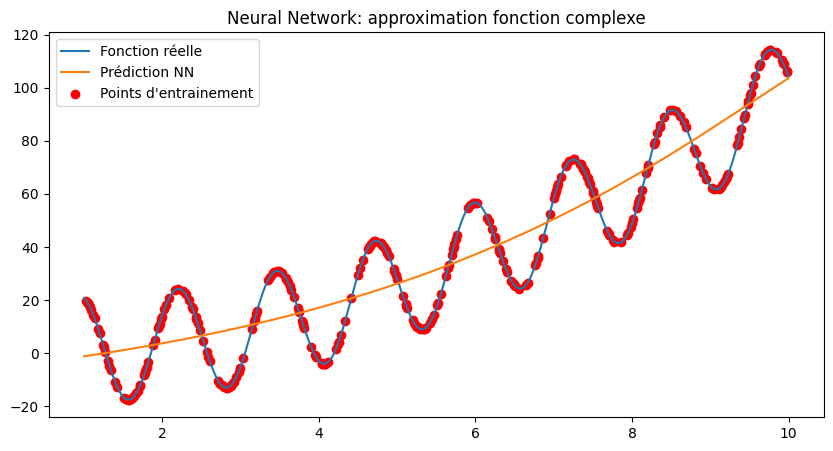

In [12]:
# Visualisation
plt.figure(figsize=(10,5))
plt.plot(x, y, label='Fonction réelle')
plt.plot(x, y_pred, label='Prédiction NN')
plt.scatter(x_chosen, y_chosen, color='red', label='Points d\'entrainement')
plt.legend()
plt.title("Neural Network: approximation fonction complexe")
plt.show()